## Import Library

In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Load Data

### Data Dictionary

| Variable | Definition | Key |
| --- | --- | --- |
| survived | Survival | 0 = No, 1 = Yes |
| pclass|	Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd
| sex|	Sex	|
| Age|	Age in years	|
| sibsp|	# of siblings / spouses aboard the Titanic	|
| parch|	# of parents / children aboard the Titanic	|
| ticket|	Ticket number	|
| fare|	Passenger fare	|
| cabin|	Cabin number	|
| embarked|	Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton

### Data Train

In [211]:
train_data = pd.read_csv("titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Pre-Processing 

In [212]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Age Feature

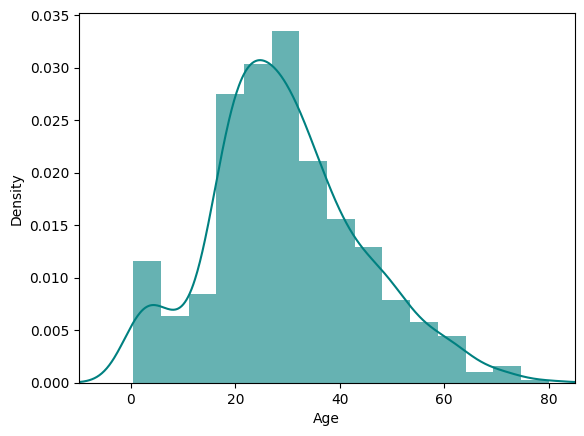

In [213]:
ax = train_data["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_data["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

Karena grafik "Age" lebih condong ke kiri, menggunakan rata-rata usia dapat memberi kita hasil yang bias. Oleh karena itu, saya memutuskan untuk menggunakan median untuk mengisi nilai yang hilang.

In [214]:
train_data["Age"].fillna(train_data["Age"].median(skipna=True), inplace=True)

#### Embarked Feature

Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


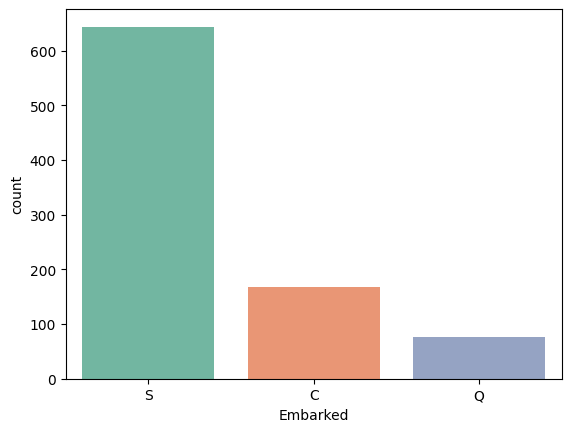

In [215]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_data['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_data, palette='Set2')
plt.show()

Karena pelabuhan keberangkatan yang paling umum adalah S (Southampton), maya saya akan mengisi 2 data hilang dengan "S".

In [216]:
train_data["Embarked"].fillna(train_data['Embarked'].value_counts().idxmax(), inplace=True)


#### Cabin Feature

Karena data yang hilang pada kolom cabin terlalu banyak, maka saya memutuskan untuk menghapus kolom tersebut. Lagipula fitur tersebut juga tidak akan berguna untuk eksplorasi saya.

In [217]:
train_data.drop('Cabin', axis=1, inplace=True)

#### Data Train Setelah di Proses

In [218]:
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

#### One Hot Encoding

In [219]:
train_data = train_data.drop(['PassengerId', 'Ticket', 'Name'], axis=1)
train_data = pd.get_dummies(train_data)
train_data

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,0,1
888,0,3,28.0,1,2,23.4500,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,1,1,0,0


# Machine Learning Modelling

In [220]:
X = train_data.drop("Survived", axis=1)
y = train_data["Survived"]
pd.concat([X, y], axis=1).head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived
0,3,22.0,1,0,7.2500,0,1,0,0,1,0
1,1,38.0,1,0,71.2833,1,0,1,0,0,1
2,3,26.0,0,0,7.9250,1,0,0,0,1,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,1
4,3,35.0,0,0,8.0500,0,1,0,0,1,0


### Building 5-folds validation

Pembagian data latih dan data uji ke dalam bentuk 5-folds validation digunakan untuk menguji kinerja model secara lebih akurat dan menghindari bias yang mungkin muncul dalam evaluasi model dengan satu set data uji dan latih. Dengan membagi data menjadi lima bagian, model dievaluasi secara iteratif dengan menggunakan kombinasi berbeda antara data uji dan latih, sehingga memberikan estimasi kinerja yang lebih stabil dan mengurangi risiko overfitting, serta memaksimalkan penggunaan data yang terbatas.

In [221]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f"\tTrain: index length = {len(train_index)}")
    print(f"\tTest:  index length= {len(test_index)}")

Fold 0:
	Train: index length = 712
	Test:  index length= 179
Fold 1:
	Train: index length = 713
	Test:  index length= 178
Fold 2:
	Train: index length = 713
	Test:  index length= 178
Fold 3:
	Train: index length = 713
	Test:  index length= 178
Fold 4:
	Train: index length = 713
	Test:  index length= 178


### Define Models

Definisikan semua model yang akan digunakan dalam memprediksi keselamatan penumpang kapal Titanic. Model-model yang digunakan meliputi Logistic Regression, Naive Bayes, K-Nearest Neighbors, Linear SVM, RBF SVM, MLP dengan 1 hidden layer, MLP dengan 2 hidden layers, Decision Tree, Random Forest, dan Gradient Boosting. 

In [222]:
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Linear SVM', LinearSVC(random_state=42)),
    ('RBF Kernel SVM', SVC(kernel='rbf', random_state=42)),
    ('MLP (1 hidden layer)', MLPClassifier(
        hidden_layer_sizes=(100,), random_state=42)),
    ('MLP (2 hidden layers)', MLPClassifier(
        hidden_layer_sizes=(100, 100), random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

### Performance Evaluation

In [223]:
# mendefinisikan daftar metrik performa
performance_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# DataFrame kosong untuk menyimpan skor kinerja dari setiap model dan fold
performance = pd.DataFrame(
    columns=['Model', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1'])
average_score = pd.DataFrame(
    columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

# loop untuk setiap model dan melaksanakan cross-validation
for name, model in models:
    print(f"Evaluating {name}")
    cv_results = cross_validate(model, X, y, cv=skf, scoring=performance_metrics)

    # mengisi nilai performa ke DataFrame 'performance'
    for i in range(skf.n_splits):
        performance.loc[len(performance)] = [name, i+1, cv_results['test_accuracy'][i],
                                   cv_results['test_precision_macro'][i],
                                   cv_results['test_recall_macro'][i],
                                   cv_results['test_f1_macro'][i]]

    # mengisi rata-rata nilai performa ke DataFrame 'average_score'
    average_score.loc[len(average_score)] = [name, cv_results['test_accuracy'].mean(),
                                cv_results['test_precision_macro'].mean(),
                                cv_results['test_recall_macro'].mean(),
                                cv_results['test_f1_macro'].mean()]
else:
    print('\nAll models trained successfully.\n')

Evaluating Logistic Regression
Evaluating Naive Bayes
Evaluating K-Nearest Neighbors


c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

Evaluating Linear SVM
Evaluating RBF SVM


c:\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluating MLP (1 hidden layer)


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating MLP (2 hidden layers)
Evaluating Decision Tree
Evaluating Random Forest
Evaluating Gradient Boosting

All models trained successfully.



### Performa setiap model dalam bentuk 5-folds validation

In [224]:
display(performance)

,Model,Fold,Accuracy,Precision,Recall,F1
0,Logistic Regression,1,0.782123,0.770204,0.768709,0.769429
1,Logistic Regression,2,0.797753,0.788515,0.777406,0.781892
2,Logistic Regression,3,0.792135,0.789283,0.761631,0.770194
3,Logistic Regression,4,0.780899,0.767917,0.769385,0.768623
4,Logistic Regression,5,0.831461,0.824779,0.817179,0.820492
5,Naive Bayes,1,0.765363,0.754329,0.763175,0.757108
6,Naive Bayes,2,0.775281,0.762311,0.759225,0.760656
7,Naive Bayes,3,0.792135,0.781712,0.772861,0.776556
8,Naive Bayes,4,0.786517,0.775082,0.768316,0.771239
9,Naive Bayes,5,0.814607,0.804245,0.808736,0.806235


### Performa rata-rata tiap model 

In [225]:
display(average_score)

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.796874,0.788139,0.778862,0.782126
1,Naive Bayes,0.786780,0.775536,0.774462,0.774359
2,K-Nearest Neighbors,0.717143,0.700151,0.692157,0.694839
3,Linear SVM,0.723847,0.743081,0.665872,0.657940
4,RBF SVM,0.678991,0.683185,0.607756,0.598097
5,MLP (1 hidden layer),0.811456,0.803493,0.794576,0.797946
6,MLP (2 hidden layers),0.806949,0.798624,0.791987,0.793966
7,Decision Tree,0.787866,0.776314,0.776107,0.775669
8,Random Forest,0.814789,0.807281,0.798499,0.801711
9,Gradient Boosting,0.827161,0.827039,0.802978,0.810978


In [227]:
# Find max values
best_accuracy_model = average_score.loc[average_score['Accuracy'].idxmax(), 'Model']
best_precision_model = average_score.loc[average_score['Precision'].idxmax(), 'Model']
best_recall_model = average_score.loc[average_score['Recall'].idxmax(), 'Model']
best_f1_model = average_score.loc[average_score['F1'].idxmax(), 'Model']

print('highest accuracy score:', best_accuracy_model)
print('highest precision score:', best_precision_model)
print('highest recall score:', best_recall_model)
print('highest F1 score:', best_f1_model)
print()

# Find lowest values
worst_accuracy_model = average_score.loc[average_score['Accuracy'].idxmin(), 'Model']
worst_precision_model = average_score.loc[average_score['Precision'].idxmin(), 'Model']
worst_recall_model = average_score.loc[average_score['Recall'].idxmin(), 'Model']
worst_f1_model = average_score.loc[average_score['F1'].idxmin(), 'Model']

print('lowest accuracy score:', worst_accuracy_model)
print('lowest precision score:', worst_precision_model)
print('lowest recall score:', worst_recall_model)
print('lowest F1 score:', worst_f1_model)

highest accuracy score: Gradient Boosting
highest precision score: Gradient Boosting
highest recall score: Gradient Boosting
highest F1 score: Gradient Boosting

lowest accuracy score: RBF SVM
lowest precision score: RBF SVM
lowest recall score: RBF SVM
lowest F1 score: RBF SVM


# Conclusion

Model Gradient Boosting adalah model terbaik untuk memprediksi keselamatan penumpang kapal Titanic. Hal tersebut dapat dilihat dari nilai rata-rata performa metric yang memiliki nilai tertinggi dibanding model lainnya. Sedangkan, model RBF Kernel SVM merupakan model terburuk untuk memprediksi keselamatan penumpang kapal Titanic karena memperoleh nilai rata-rata performa metric yang paling rendah. 

Dalam kasus dataset Titanic, Gradient Boosting memiliki tingkat performa terbaik karena model ini memiliki kemampuan yang baik dalam menangani masalah klasifikasi dengan dataset yang kompleks dan beragam fitur. Gradient Boosting mampu membangun sekumpulan pohon keputusan yang kuat dan memperbaikinya secara bertahap dengan menggabungkan hasil prediksi dari pohon sebelumnya, sehingga mampu mengatasi masalah overfitting dan memberikan prediksi yang akurat.

Di sisi lain, SVM dengan kernel RBF (Radial Basis Function) menghasilkan tingkat performa yang lebih rendah dalam kasus dataset Titanic. Hal ini bisa terjadi karena SVM dengan kernel RBF memiliki kecenderungan untuk overfitting ketika dihadapkan pada dataset yang memiliki fitur yang banyak atau dimensi yang tinggi seperti dataset Titanic. Selain itu, dalam SVM dengan kernel RBF, ada parameter kernel yang harus disesuaikan dengan baik untuk mendapatkan performa yang optimal. Jika parameter kernel tidak disesuaikan dengan baik, performa model dapat menurun.

Namun, penting untuk dicatat bahwa performa model-machine learning dapat bervariasi tergantung pada berbagai faktor, termasuk praproses data yang dilakukan, pengaturan parameter model, dan metrik evaluasi yang digunakan. Oleh karena itu, eksperimen yang lebih lengkap dan pengaturan yang lebih tepat diperlukan untuk memastikan hasil evaluasi performa model yang lebih akurat dan dapat diandalkan.